In [3]:
 pip install -q kaggle

In [4]:
from google.colab import files

In [5]:
files.upload() #upload kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mirtavucinic","key":"c4136663ac663d4e32c581d094f31cb7"}'}

In [6]:
! mkdir ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00


In [10]:
! pip install pydub

In [11]:
import pandas as pd
import numpy as np
import librosa
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    Conv2D,
    LSTM,
    Bidirectional,
    Dropout,
    BatchNormalization,
    Dense,
    MaxPooling1D,
    MaxPooling2D,
    concatenate,
    GlobalAveragePooling1D,
    Flatten,
)

import librosa.display
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import save_model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
import soundfile as sf
import random
import os
from pydub import AudioSegment

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix, roc_curve, classification_report

warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
np.random.seed(42)
tf.random.set_seed(42)

In [12]:
! kaggle datasets download birdy654/deep-voice-deepfake-voice-recognition

Dataset URL: https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition
License(s): other
100% 3.68G/3.69G [00:29<00:00, 116MB/s]
100% 3.69G/3.69G [00:29<00:00, 132MB/s]


In [13]:
!unzip deep-voice-deepfake-voice-recognition.zip -d /content/dataset

Archive:  deep-voice-deepfake-voice-recognition.zip
  inflating: /content/dataset/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3  
  inflating: /content/dataset/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/Obama-to-Biden.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/Obama-to-Trump.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-Obama.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-Trump.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-linus.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-margot.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-musk.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-ryan.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/biden-to-taylor.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/linus-to-biden.wav  
  inflating: /content/dataset/KAGGLE/AUDIO/FAKE/linus-to-margot.wav  
  inflating: /content

In [14]:

dataset_path = "/content/dataset/KAGGLE/AUDIO"
augmented_dataset_path = "/kaggle/working/SPLITTED"

os.makedirs(augmented_dataset_path, exist_ok=True)
os.makedirs(os.path.join(augmented_dataset_path, "FAKE"), exist_ok=True)
os.makedirs(os.path.join(augmented_dataset_path, "REAL"), exist_ok=True)

def split_audio_file(file_path, output_dir, segment_length=10):
    audio = AudioSegment.from_wav(file_path)
    duration = audio.duration_seconds
    segment_length_ms = segment_length * 1000

    segments = []
    for i in range(0, len(audio), segment_length_ms):
        segment = audio[i:i + segment_length_ms]
        segment_file_name = f"{os.path.splitext(os.path.basename(file_path))[0]}_part{i // segment_length_ms}.wav"
        segment_path = os.path.join(output_dir, segment_file_name)
        segment.export(segment_path, format="wav")
        segments.append(segment_path)
    return segments

real_samples_path = os.path.join(dataset_path, "REAL")
for file_name in os.listdir(real_samples_path):
    file_path = os.path.join(real_samples_path, file_name)
    output_dir = os.path.join(augmented_dataset_path, "REAL")
    split_audio_file(file_path, output_dir)

fake_samples_path = os.path.join(dataset_path, "FAKE")
fake_segments = []
for file_name in os.listdir(fake_samples_path):
    file_path = os.path.join(fake_samples_path, file_name)
    output_dir = os.path.join(augmented_dataset_path, "FAKE")
    fake_segments.extend(split_audio_file(file_path, output_dir))

selected_fake_segments = random.sample(fake_segments, len(os.listdir("/kaggle/working/SPLITTED/REAL")))

selected_fake_path = os.path.join(augmented_dataset_path, "SELECTED_FAKE")
os.makedirs(selected_fake_path, exist_ok=True)
for segment in selected_fake_segments:
    segment_file_name = os.path.basename(segment)
    os.rename(segment, os.path.join(selected_fake_path, segment_file_name))

<ipython-input-15-da10bd04fdfc>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=data_pre_augmentation, ax=axes[0], palette=['#1f77b4', '#ff7f0e'])
<ipython-input-15-da10bd04fdfc>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=data_post_augmentation, ax=axes[1], palette=['#1f77b4', '#ff7f0e'])


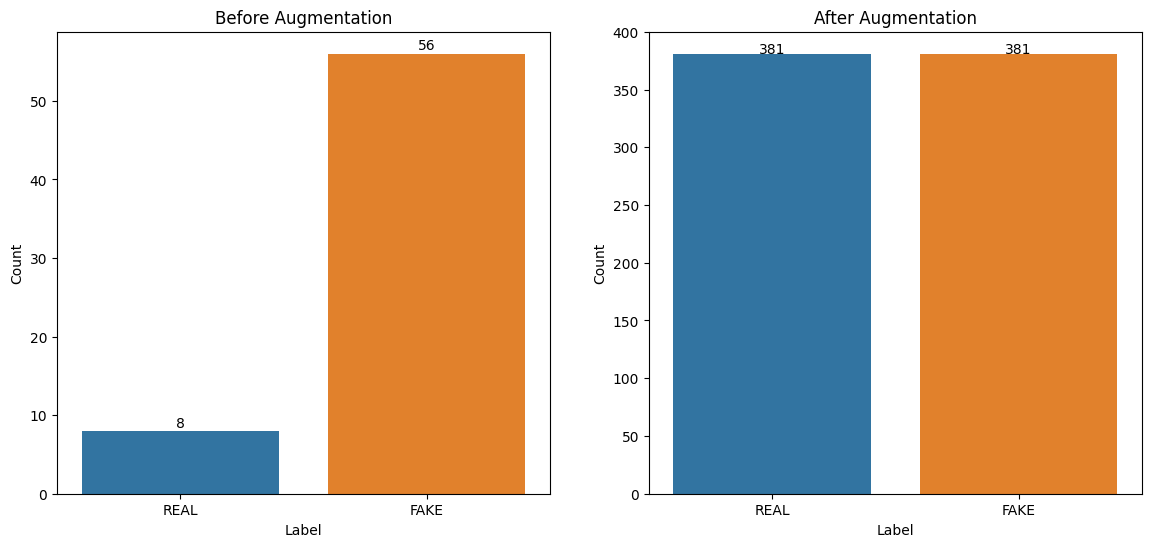

In [15]:

original_real_path = os.path.join(dataset_path, "REAL")
original_fake_path = os.path.join(dataset_path, "FAKE")
augmented_real_path = os.path.join(augmented_dataset_path, "REAL")
augmented_fake_path = os.path.join(augmented_dataset_path, "SELECTED_FAKE")

num_original_real = len(os.listdir(original_real_path))
num_original_fake = len(os.listdir(original_fake_path))


num_augmented_real = len(os.listdir(augmented_real_path))
num_augmented_fake = len(os.listdir(augmented_fake_path))


data_pre_augmentation = {'Label': ['REAL', 'FAKE'], 'Count': [num_original_real, num_original_fake]}
data_post_augmentation = {'Label': ['REAL', 'FAKE'], 'Count': [num_augmented_real, num_augmented_fake]}


fig, axes = plt.subplots(1, 2, figsize=(14, 6))


sns.barplot(x='Label', y='Count', data=data_pre_augmentation, ax=axes[0], palette=['#1f77b4', '#ff7f0e'])
axes[0].set_title('Before Augmentation')
for i, count in enumerate(data_pre_augmentation['Count']):
    axes[0].text(i, count + 0.5, str(count), ha='center')


sns.barplot(x='Label', y='Count', data=data_post_augmentation, ax=axes[1], palette=['#1f77b4', '#ff7f0e'])
axes[1].set_title('After Augmentation')
for i, count in enumerate(data_post_augmentation['Count']):
    axes[1].text(i, count + 0.5, str(count), ha='center')

plt.show()

In [16]:

def extract_features(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)

fake_samples_path = "/kaggle/working/SPLITTED/SELECTED_FAKE"
real_samples_path = "/kaggle/working/SPLITTED/REAL"

features = []
labels = []

for file_name in os.listdir(fake_samples_path):
    file_path = os.path.join(fake_samples_path, file_name)
    if file_path.endswith('.wav'):
        features.append(extract_features(file_path))
        labels.append(0)


for file_name in os.listdir(real_samples_path):
    file_path = os.path.join(real_samples_path, file_name)
    if file_path.endswith('.wav'):
        features.append(extract_features(file_path))
        labels.append(1)

X = np.array(features)
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("5 rows of extracted features:")
for i in range(5):
    print(f"Features: {X[i]}, Label: {y[i]}")


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=144
  warnings.warn(


5 rows of extracted features:
Features: [-340.4035     105.46594     -1.6968532   14.321297   -13.593978
    6.595667   -10.882458    -3.6185234   -9.481471    -6.8158073
   -6.055868     2.1784816  -11.298341 ], Label: 0
Features: [-323.26892    142.2464     -47.96674     18.922209   -18.98452
  -12.326708   -21.545033   -15.382391    -1.1086578   -5.734995
   -5.9942904   -4.623303    -9.180251 ], Label: 0
Features: [-4.2073376e+02  6.4884033e+01  2.7973502e+00  2.7387875e+01
 -6.1225910e-02  4.8374705e+00 -3.8600187e+00 -2.4713290e+00
 -6.3110375e+00 -2.0227258e+00 -2.3110495e+00 -3.3332782e+00
  1.7403075e+00], Label: 0
Features: [-4.3545374e+02  7.3140495e+01 -2.5267435e+01  1.3840720e+01
  7.2936797e+00  1.1899312e+00 -9.8393002e+00 -3.5716712e+00
 -3.4001017e+00 -3.9651525e-01 -5.3224170e-01  9.5632464e-02
 -1.2303512e+00], Label: 0
Features: [-258.6265     145.95905    -36.581436   -18.374365   -18.33936
  -13.0703125  -25.575266   -10.691925    -5.327854    -9.098819
   -3.917

In [17]:
model_accuracy={}

# Naive Bayes

In [18]:
model = GaussianNB()


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["Naive Bayes"] = accuracy

Accuracy: 0.8169934640522876
Precision: 0.8529411764705882
Recall: 0.7631578947368421
F1-score: 0.8055555555555556


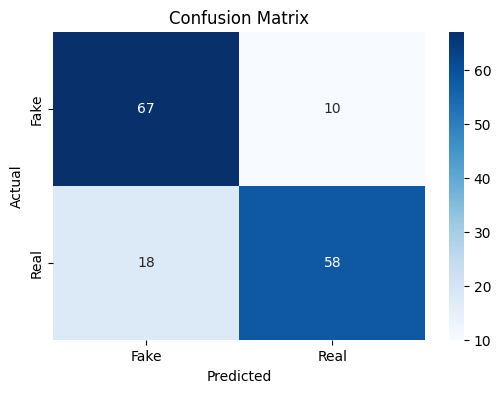

In [19]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83        77
           1       0.85      0.76      0.81        76

    accuracy                           0.82       153
   macro avg       0.82      0.82      0.82       153
weighted avg       0.82      0.82      0.82       153



# K-Nearest Neighbors (KNN)



In [29]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

Best parameters: {'knn__n_neighbors': 3, 'knn__p': 2, 'knn__weights': 'uniform', 'selector__k': 11}
Best score: 0.9918032786885245


In [30]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [31]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["SVM"] = accuracy

Accuracy: 0.9803921568627451
Precision: 0.9620253164556962
Recall: 1.0
F1-score: 0.9806451612903225


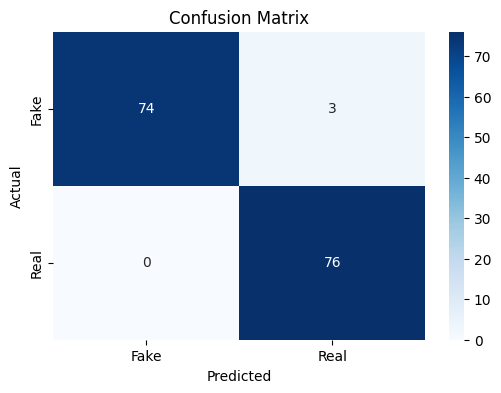

In [32]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        77
           1       0.96      1.00      0.98        76

    accuracy                           0.98       153
   macro avg       0.98      0.98      0.98       153
weighted avg       0.98      0.98      0.98       153



# Support Vector Machine (SVM)

In [34]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('svm', SVC(probability=True))
])

param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['linear', 'rbf']
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

Best parameters: {'selector__k': 13, 'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best score: 0.9901639344262294


In [35]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [36]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["SVM"] = accuracy

Accuracy: 0.9934640522875817
Precision: 0.987012987012987
Recall: 1.0
F1-score: 0.9934640522875817


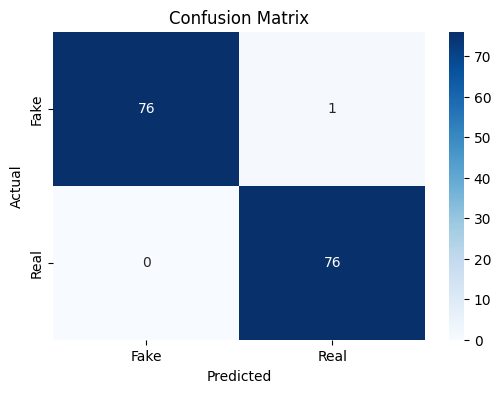

In [37]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        77
           1       0.99      1.00      0.99        76

    accuracy                           0.99       153
   macro avg       0.99      0.99      0.99       153
weighted avg       0.99      0.99      0.99       153



# Logistic Regression

In [48]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear', 'saga']
}


grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best parameters: {'lr__C': 0.1, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'selector__k': 13}
Best score: 0.8488958135753963


In [49]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["Logistic Regression"] = accuracy

Accuracy: 0.803921568627451
Precision: 0.8709677419354839
Recall: 0.7105263157894737
F1-score: 0.782608695652174


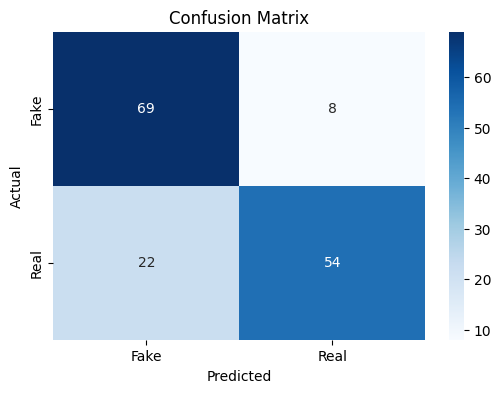

In [50]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.90      0.82        77
           1       0.87      0.71      0.78        76

    accuracy                           0.80       153
   macro avg       0.81      0.80      0.80       153
weighted avg       0.81      0.80      0.80       153



# Random Forest

In [43]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('rf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'rf__n_estimators': [200, 300],
    'rf__max_depth': [None, 10, 20],
    'rf__bootstrap': [True, False]
}


grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)


grid_search.fit(X_train, y_train)


print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best parameters: {'rf__bootstrap': True, 'rf__max_depth': 10, 'rf__n_estimators': 200, 'selector__k': 13}
Best score: 0.9753556428668201


In [44]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["Random Forest"] = accuracy

Accuracy: 0.9411764705882353
Precision: 0.9240506329113924
Recall: 0.9605263157894737
F1-score: 0.9419354838709677


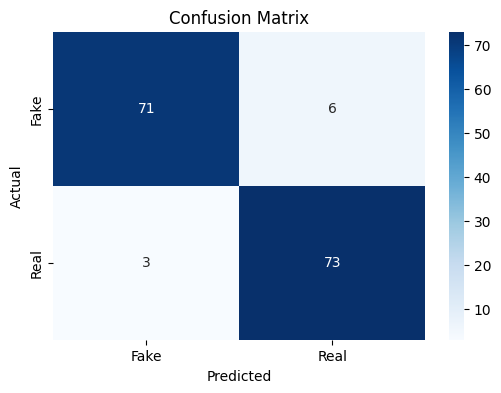

In [45]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        77
           1       0.92      0.96      0.94        76

    accuracy                           0.94       153
   macro avg       0.94      0.94      0.94       153
weighted avg       0.94      0.94      0.94       153



# Decision Tree

In [52]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

param_grid = {
    'selector__k': [3, 6, 9, 11, 13],
    'dt__max_depth': [None, 10, 20, 30],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


Best parameters: {'dt__criterion': 'gini', 'dt__max_depth': None, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 5, 'selector__k': 13}
Best score: 0.9129657228017883


In [53]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["Decision Tree"] = accuracy

Accuracy: 0.9019607843137255
Precision: 0.9295774647887324
Recall: 0.868421052631579
F1-score: 0.8979591836734694


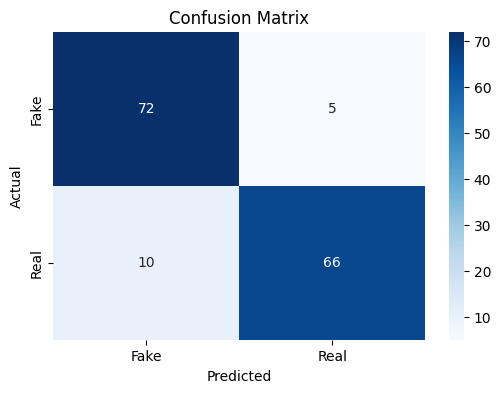

In [54]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        77
           1       0.93      0.87      0.90        76

    accuracy                           0.90       153
   macro avg       0.90      0.90      0.90       153
weighted avg       0.90      0.90      0.90       153



# CatBoost

In [56]:
catboost= CatBoostClassifier(verbose=0, random_state=42)

catboost.fit(X_train, y_train)

y_pred = catboost.predict(X_test)

In [57]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["CatBoost"] = accuracy

Accuracy: 0.9803921568627451
Precision: 0.9620253164556962
Recall: 1.0
F1-score: 0.9806451612903225


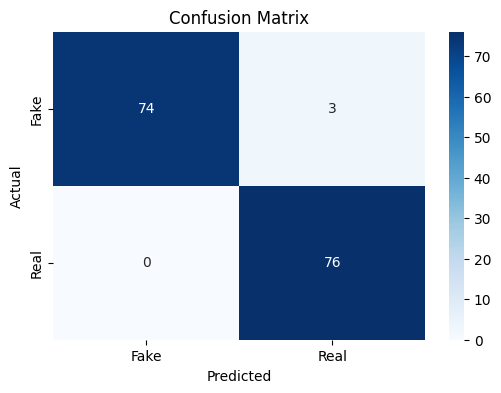

In [58]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        77
           1       0.96      1.00      0.98        76

    accuracy                           0.98       153
   macro avg       0.98      0.98      0.98       153
weighted avg       0.98      0.98      0.98       153



# eXtreme Gradient Boosting (XGB)

In [60]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
model_accuracy["XGB"] = accuracy

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:27:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9738562091503268
Precision: 0.95
Recall: 1.0
F1-score: 0.9743589743589743


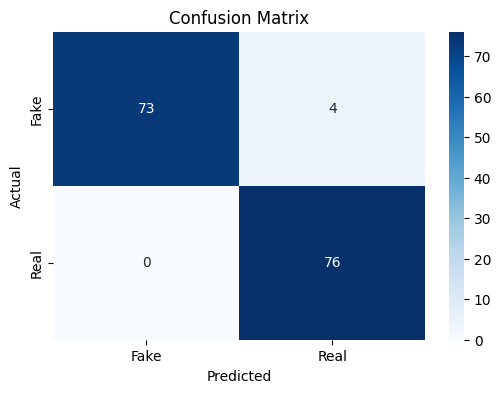

In [61]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        77
           1       0.95      1.00      0.97        76

    accuracy                           0.97       153
   macro avg       0.97      0.97      0.97       153
weighted avg       0.98      0.97      0.97       153



# Long Short-Term Memory (LSTM)

In [63]:

def extract_mfcc_sequence(file_path, n_mfcc=13, max_length=100):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs = mfccs.T
    mfccs = pad_sequences([mfccs], maxlen=max_length, padding='post', truncating='post')[0]
    return mfccs

features = []
labels = []

for file_name in os.listdir(fake_samples_path):
    file_path = os.path.join(fake_samples_path, file_name)
    if file_path.endswith('.wav'):
        features.append(extract_mfcc_sequence(file_path))
        labels.append(0)

for file_name in os.listdir(real_samples_path):
    file_path = os.path.join(real_samples_path, file_name)
    if file_path.endswith('.wav'):
        features.append(extract_mfcc_sequence(file_path))
        labels.append(1)


X = np.array(features)
y = np.array(labels)

y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=144
  warnings.warn(


In [64]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dense(2, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)
model.summary()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
model_accuracy["LSTM"] = accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 266ms/step - accuracy: 0.5535 - loss: 0.6969 - val_accuracy: 0.6732 - val_loss: 0.6154
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 382ms/step - accuracy: 0.6835 - loss: 0.6113 - val_accuracy: 0.7582 - val_loss: 0.5203
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - accuracy: 0.7701 - loss: 0.5060 - val_accuracy: 0.7712 - val_loss: 0.4661
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 389ms/step - accuracy: 0.8378 - loss: 0.3835 - val_accuracy: 0.8366 - val_loss: 0.4264
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.8161 - loss: 0.3863 - val_accuracy: 0.8889 - val_loss: 0.3203
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step - accuracy: 0.9187 - loss: 0.2430 - val_accuracy: 0.8497 - val_loss: 0.3542
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - accuracy: 0.9066 - loss: 0.2171 - val_accuracy: 0.9020 - val_loss: 0.2467
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 458ms/step - accuracy: 0.9619 - loss: 0.1562 - val_accuracy: 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 128)            │          72,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 403,784 (1.54 MB)

 Trainable params: 134,594 (525.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 269,190 (1.03 MB)

Test Loss: 0.19751742482185364
Test Accuracy: 0.9215686321258545


In [ ]:
# model = Sequential()
# model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.5))
# model.add(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.5))
# model.add(LSTM(16, kernel_regularizer=l2(0.001)))
# model.add(Dense(2, activation='softmax'))

# model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# loss, accuracy = model.evaluate(X_test, y_test)
# print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.4658 - loss: 0.8602 - val_accuracy: 0.4902 - val_loss: 0.8390
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5240 - loss: 0.8414 - val_accuracy: 0.5294 - val_loss: 0.8304
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.4936 - loss: 0.8459 - val_accuracy: 0.6078 - val_loss: 0.8228
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.5399 - loss: 0.8312 - val_accuracy: 0.6144 - val_loss: 0.8162
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.5745 - loss: 0.8134 - val_accuracy: 0.5948 - val_loss: 0.8107
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.6157 - loss: 0.8096 - val_accuracy: 0.6013 - val_loss: 0.8042
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5930 - loss: 0.7998 - val_accuracy: 0.6144 - val_loss: 0.7979
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.6166 - loss: 0.7963 - val_accuracy: 0.

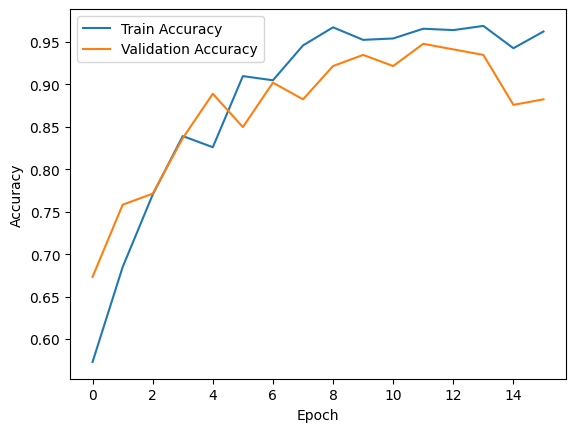

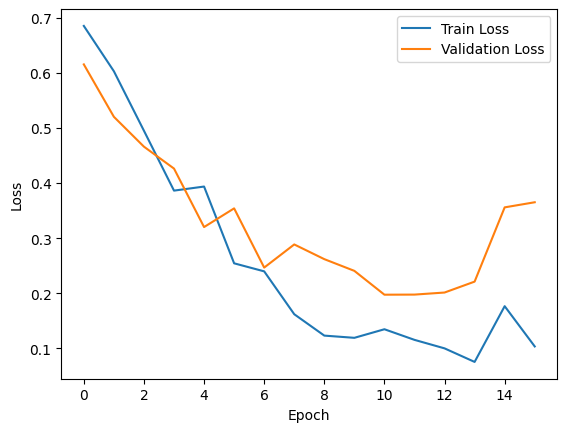

In [65]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Convolutional Neural Network (CNN)

In [ ]:
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
# X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# model = Sequential([
#     Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
#     MaxPooling1D(2),
#     Dropout(0.2),
#     Conv1D(128, 3, activation='relu'),
#     MaxPooling1D(2),
#     Dropout(0.2),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dropout(0.5),
#     Dense(y.shape[1], activation='softmax')
# ])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stopping])

# loss, accuracy = model.evaluate(X_test, y_test)
# print(f"Test Loss: {loss}")
# print(f"Test Accuracy: {accuracy}")

In [ ]:
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
# from tensorflow.keras.optimizers import Adam
# import numpy as np

# model = Sequential([
#     Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
#     MaxPooling1D(2),
#     Dropout(0.4),

#     Conv1D(128, 3, activation='relu'),
#     MaxPooling1D(2),
#     Dropout(0.4),


#     Conv1D(256, 3, activation='relu'),
#     MaxPooling1D(2),
#     Dropout(0.4),

#     Flatten(),

#     Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
#     Dropout(0.5),

#     Dense(y.shape[1], activation='softmax')
# ])

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=50,
#     batch_size=32,
#     callbacks=[early_stopping]
# )


# loss, accuracy = model.evaluate(X_test, y_test)
# print(f"Test Loss: {loss}")
# print(f"Test Accuracy: {accuracy}")


In [ ]:
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [66]:
def save_spectrogram(file_path, output_dir, n_mels=128, fmax=8000):
    y, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    plt.figure(figsize=(3, 3))
    librosa.display.specshow(spectrogram_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel', fmax=fmax)
    plt.axis('off')
    output_path = os.path.join(output_dir, os.path.basename(file_path).replace('.wav', '.png'))
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

fake_output_dir = "/kaggle/working/SPECTROGRAMS/FAKE"
real_output_dir = "/kaggle/working/SPECTROGRAMS/REAL"
os.makedirs(fake_output_dir, exist_ok=True)
os.makedirs(real_output_dir, exist_ok=True)

for file_name in os.listdir(fake_samples_path):
    file_path = os.path.join(fake_samples_path, file_name)
    if file_path.endswith('.wav'):
        save_spectrogram(file_path, fake_output_dir)

for file_name in os.listdir(real_samples_path):
    file_path = os.path.join(real_samples_path, file_name)
    if file_path.endswith('.wav'):
        save_spectrogram(file_path, real_output_dir)


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=144
  warnings.warn(


FAKE Spectrograms:


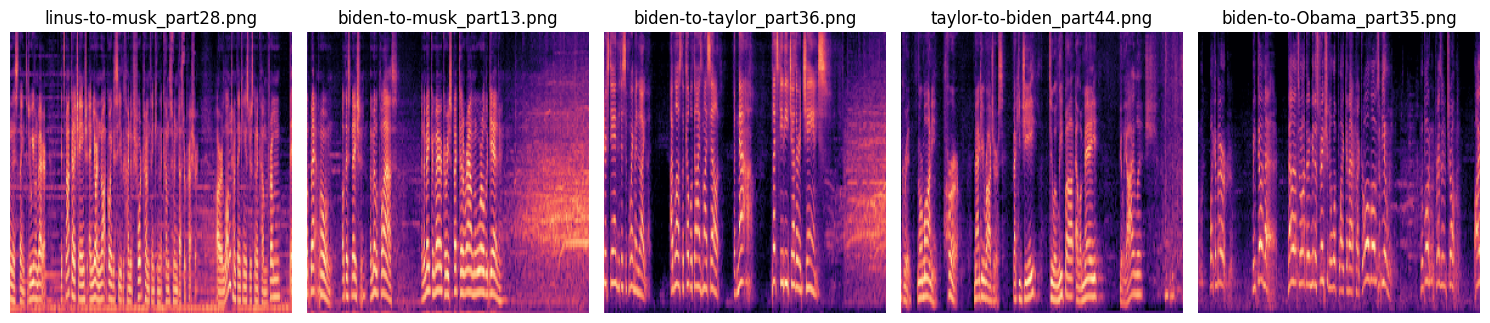


REAL Spectrograms:


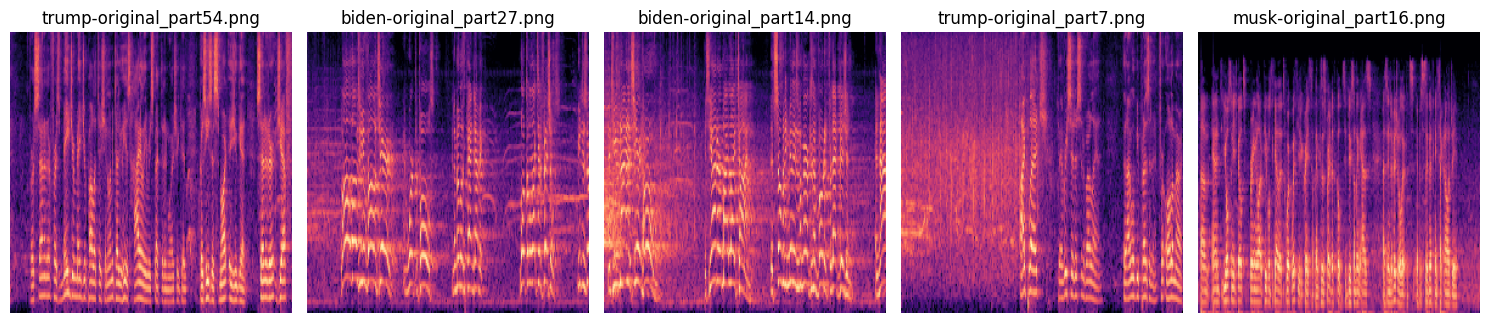

In [73]:
from PIL import Image

def display_spectrograms(directory, num_images=5):
    image_files = [f for f in os.listdir(directory) if f.endswith('.png')]
    if len(image_files) == 0:
        print("Nema dostupnih spektrograma u direktoriju.")
        return

    num_images = min(num_images, len(image_files))
    plt.figure(figsize=(15, 5))

    for i, file_name in enumerate(image_files[:num_images]):
        file_path = os.path.join(directory, file_name)
        img = Image.open(file_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(file_name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Examples of FAKE Spectrograms:")
display_spectrograms(fake_output_dir, num_images=5)
print()
print("Examples of REAL Spectrograms:")
display_spectrograms(real_output_dir, num_images=5)

In [74]:
train_dir = "/kaggle/working/SPECTROGRAMS"
batch_size = 32
img_height, img_width = 128, 128

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)


validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 610 images belonging to 2 classes.
Found 152 images belonging to 2 classes.


In [ ]:
# model = Sequential()

# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.3))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.3))

# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(2, activation='softmax'))


# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# history = model.fit(
#     train_generator,
#     epochs=20,
#     validation_data=validation_generator,
#     callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
# )

# loss, accuracy = model.evaluate(validation_generator)
# print(f"Validation Loss: {loss}")
# print(f"Validation Accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5247 - loss: 7.0637 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6631 - loss: 0.5945 - val_accuracy: 0.5132 - val_loss: 0.6931
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7063 - loss: 0.5610 - val_accuracy: 0.5658 - val_loss: 0.6806
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7667 - loss: 0.4539 - val_accuracy: 0.5461 - val_loss: 0.6692
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7891 - loss: 0.4763 - val_accuracy: 0.6053 - val_loss: 0.6514
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7853 - loss: 0.4710 - val_accuracy: 0.7105 - val_loss: 0.5991
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8181 - loss: 0.4161 - val_accuracy: 0.7303 - val_loss: 0.6553
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8070 - loss: 0.3824 - val_accuracy: 0.7895 - val_loss: 0.6196
Epo

In [77]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")
model_accuracy["CNN"] = accuracy

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5014 - loss: 1.1081 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5085 - loss: 0.6926 - val_accuracy: 0.5461 - val_loss: 0.6871
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.6436 - loss: 0.6709 - val_accuracy: 0.7039 - val_loss: 0.6148
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7559 - loss: 0.5549 - val_accuracy: 0.8092 - val_loss: 0.4997
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7577 - loss: 0.5174 - val_accuracy: 0.8092 - val_loss: 0.4727
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8421 - loss: 0.4339 - val_accuracy: 0.8289 - val_loss: 0.4175
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8043 - loss: 0.4199 - val_accuracy: 0.8355 - val_loss: 0.3985
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8865 - loss: 0.2954 - val_accuracy: 0.8224 - val_loss:

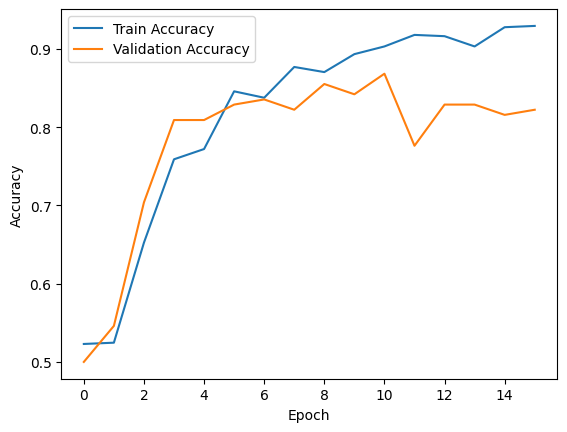

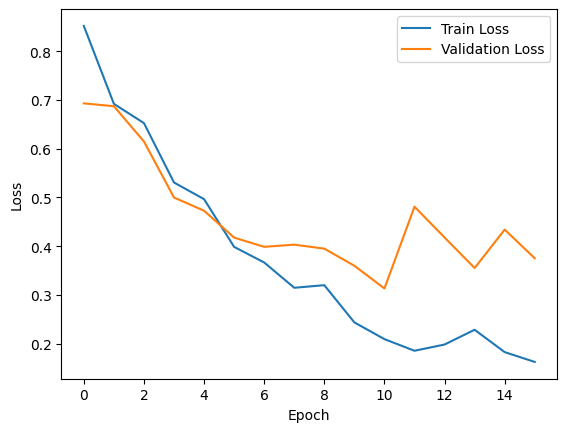

In [78]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

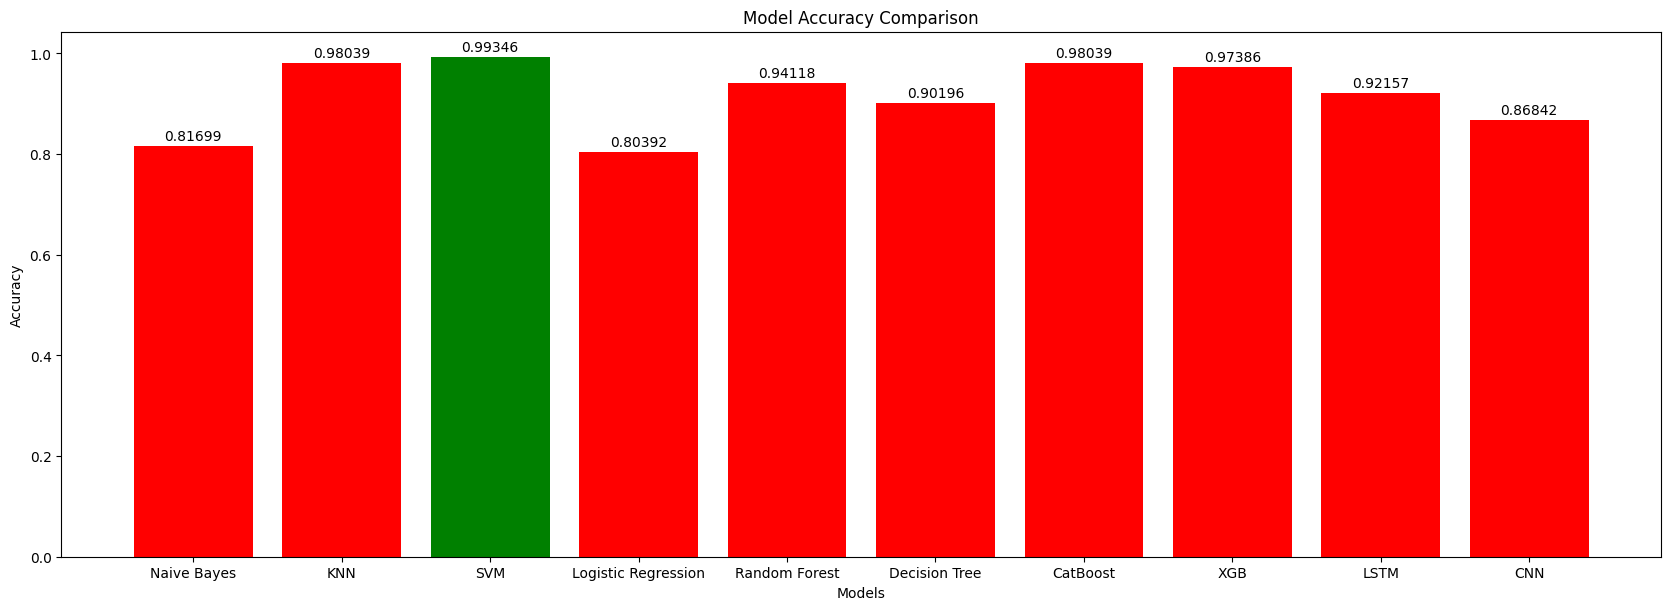

In [110]:
models = list(model_accuracy.keys())
accuracies = list(model_accuracy.values())

max_index = accuracies.index(max(accuracies))
colors = ['green' if i == max_index else 'red' for i in range(len(models))]

plt.figure(figsize=(20, 7))
plt.bar(models, accuracies, color=colors)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.15)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.5f}", ha='center', va='bottom')
plt.show()